# **ThermalNet by GBC&Co.**

##Installs

In [ ]:
!pip install PyDrive
!pip install gdown
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cpu
!pip install loguru
!pip install pytorch_lightning
!pip pip install matplotlib networkx
!pip install kornia
!pip uninstall -y torchmetrics
!pip install torchmetrics
!pip uninstall -y torch torchvision
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python
!pip install pydrive2
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.168.0
    Uninstalling google-api-python-client-2.168.0:
      Successfully uninstalled google-api-python-client-2.168.0
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 33.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

## Libraries

In [ ]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import sys

import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import torch
import torch.nn.functional as F
import kornia as K

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing & Augmentation

### Data Preprocessing

#### 1. Define the Dataset Class




This section involves defining the ThermalRGBDataset class, which handles the loading and preprocessing of RGB and thermal image pairs. Key points:
- _load_pairs(): Loads pairs of thermal and visible images by matching filenames.
- \_\_len\_\_: Returns the total number of paired images in the dataset.
- \_\_getitem\_\_: Loads and preprocesses RGB and thermal images by resizing, normalizing, and applying transformations.

In [ ]:
# Define rgb_augmentation
def rgb_augmentation(pil_image):
    """
    Apply random augmentations to an RGB image using torchvision transforms.
    """
    augmentation = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    return augmentation(pil_image)

# Define add_noise
def add_noise(image):
    """
    Add random Gaussian noise to a thermal image.
    """
    mean = 0
    stddev = 0.05
    noise = np.random.normal(mean, stddev, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Your Dataset class and DataLoader logic remain unchanged

class ThermalRGBDataset(Dataset):
    def __init__(self, base_dir, condition, img_size=(640, 480), augment=False, transform=None):
        """
        Initialize the dataset.

        Args:
            base_dir (str): Path to the dataset root directory.
            condition (str): 'cloudy' or 'sunny'.
            img_size (tuple): Target image size (width, height).
            augment (bool): Whether to apply augmentations.
            transform (callable): Additional transforms to apply.
        """
        self.base_dir = base_dir
        self.condition = condition
        self.img_size = img_size
        self.augment = augment
        self.transform = transform
        self.pairs = self._load_pairs()

    def _load_pairs(self):
        """
        Load paired thermal and visible images.
        """
        pairs = []
        condition_path = os.path.join(self.base_dir, self.condition)
        scenes = [os.path.join(condition_path, scene) for scene in os.listdir(condition_path) if scene.startswith("scene")]
        for scene in scenes:
            thermal_path = os.path.join(scene, "thermal/images")
            visible_path = os.path.join(scene, "visible/images")

            thermal_files = sorted(os.listdir(thermal_path))
            visible_files = sorted(os.listdir(visible_path))
            for thermal, visible in zip(thermal_files, visible_files):
                pairs.append((os.path.join(thermal_path, thermal), os.path.join(visible_path, visible)))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Load and preprocess a single pair of images.
        """
        thermal_path, visible_path = self.pairs[idx]

        # Load images
        thermal_img = cv2.imread(thermal_path, cv2.IMREAD_GRAYSCALE)
        visible_img = cv2.imread(visible_path)

        # Resize images
        thermal_img = cv2.resize(thermal_img, self.img_size)
        visible_img = cv2.resize(visible_img, self.img_size)

        # Normalize images
        thermal_img = thermal_img / 255.0
        visible_img = visible_img / 255.0

        # Apply augmentations if specified
        if self.augment:
            # --- Suggested Changes ---
            # Convert visible image to a PyTorch tensor before augmentations
            visible_img = transforms.ToTensor()(visible_img)
            # --- End of Suggested Changes ---

            # Augment visible (RGB) image
            visible_img = rgb_augmentation(transforms.ToPILImage()(visible_img))
            visible_img = np.array(visible_img) / 255.0  # Convert back to numpy

            # Augment thermal image
            thermal_img = add_noise(thermal_img)

        # Apply transforms if provided
        if self.transform:
            visible_img = self.transform(visible_img)
            thermal_img = self.transform(thermal_img)

        # Convert thermal image to tensor and add a channel dimension
        thermal_img = torch.tensor(thermal_img, dtype=torch.float32).unsqueeze(0)

        return visible_img, thermal_img

#### 2. The Visualization Function



This part defines a helper function visualize_pair() to display paired RGB and thermal images side by side.
- Converts PyTorch tensors back into images.
- Visualizes RGB in color and thermal images using a heatmap (e.g., hot colormap).

Processing condition: sunny
Condition: sunny, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


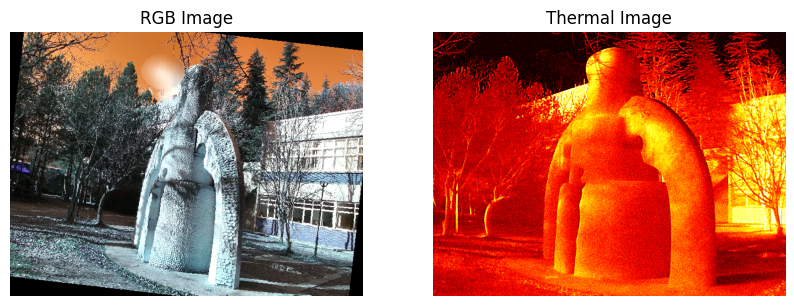

Processing condition: cloudy
Condition: cloudy, Visible Image Shape: torch.Size([8, 480, 640, 3]), Thermal Image Shape: torch.Size([8, 1, 480, 640])


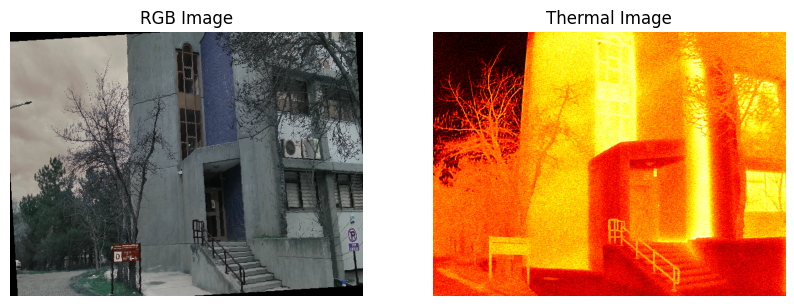

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def visualize_pair(rgb, thermal):
    """
    Visualize an RGB and thermal image pair.
    """

    # Ensure RGB image is in the correct format for imshow
    if isinstance(rgb, torch.Tensor):
        rgb = rgb.cpu().numpy()  # Convert to NumPy array
    if rgb.dtype != np.uint8:
        rgb = (rgb * 255).astype(np.uint8)  # Convert to uint8 if needed
    if len(rgb.shape) == 3 and rgb.shape[0] in (1, 3):  # If channels are first, move to last
        rgb = rgb.transpose(1, 2, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(thermal.squeeze(0).numpy(), cmap="hot")
    plt.title("Thermal Image")
    plt.axis("off")
    plt.show()

# Define the base directory of the dataset
base_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"

# List all conditions dynamically (e.g., `cloudy`, `sunny`) and exclude invalid directories
conditions = [
    condition for condition in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, condition)) and condition not in ['index']
]

# Iterate over each condition
dataloaders = {}
for condition in conditions:
    print(f"Processing condition: {condition}")

    # Initialize the dataset for the current condition
    try:
        dataset = ThermalRGBDataset(
            base_dir=base_dir,
            condition=condition,
            img_size=(640, 480),  # Resize to 640x480
            augment=True,         # Enable augmentation
            transform=None        # PyTorch transformations, if needed
        )

        # Create a DataLoader for the current condition
        dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
        dataloaders[condition] = dataloader  # Save DataLoader for later use

        # Optionally: Visualize a sample from each condition
        for visible_img, thermal_img in dataloader:
            print(f"Condition: {condition}, Visible Image Shape: {visible_img.shape}, Thermal Image Shape: {thermal_img.shape}")
            visualize_pair(visible_img[0], thermal_img[0])  # Visualize the first pair
            break

    except FileNotFoundError as e:
        print(f"Skipping condition {condition}: {e}")

### Data Augmentation

We will apply three augmentation techniques:
1. Random Hue, Saturation, and Value (HSV) Adjustment
2. Conversion to Grayscale
3. Cosine Transformation
4. Gaussian Blur

As for the final step, we will create the pipeline to apply the techniques mentioned above.

In [ ]:
# Define paths
input_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR"
output_dir = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Augmentation functions
def adjust_hsv(image):
    """Adjust hue, saturation, and value of the image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue_adjust = np.random.uniform(-10, 10)
    sat_scale = np.random.uniform(0.8, 1.2)
    val_scale = np.random.uniform(0.8, 1.2)
    hsv[:, :, 0] = np.clip(hsv[:, :, 0] + hue_adjust, 0, 180)  # Adjust hue
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * sat_scale, 0, 255)   # Scale saturation
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * val_scale, 0, 255)   # Scale value
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def convert_to_grayscale(image):
    """Convert RGB image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def cosine_transform(image):
    """Apply randomized cosine transformation to grayscale image."""
    image = image / 255.0  # Normalize to [0, 1]
    w0, wr, theta_r = 2 * np.pi / 3, np.pi / 2, np.pi / 2
    alpha0, alpha1 = np.random.normal(0, 0.1), np.random.normal(0, 0.1)
    w = w0 + abs(alpha0) * wr
    theta = np.pi / 2 + alpha1 * theta_r
    transformed = np.cos(w * (image - 0.5) + theta)
    transformed = (transformed - transformed.min()) / (transformed.max() - transformed.min())  # Normalize
    return (transformed * 255).astype(np.uint8)

def apply_gaussian_blur(image):
    """Apply Gaussian blur to smooth the image."""
    return cv2.GaussianBlur(image, (5, 5), 0)



The complete pipeline

In [ ]:
# Full augmentation pipeline
def augment_and_process(image):
    """
    Full pipeline for augmenting and preprocessing an image.
    Returns a dictionary of processed steps.
    """
    results = {}

    # Original image
    results["original"] = image

    # Step 1: Adjust HSV
    augmented_rgb = adjust_hsv(image)
    results["hsv_adjusted"] = augmented_rgb

    # Step 2: Convert to Grayscale
    grayscale_image = convert_to_grayscale(augmented_rgb)
    results["grayscale"] = grayscale_image

    # Step 3: Apply Cosine Transformation
    pseudo_thermal = cosine_transform(grayscale_image)
    results["cosine_transformed"] = pseudo_thermal

    # Step 4: Apply Gaussian Blur
    smoothed_thermal = apply_gaussian_blur(pseudo_thermal)
    results["gaussian_blurred"] = smoothed_thermal

    return results

#### Download the augmented dataset to drive

In [ ]:
# Function to traverse dataset and apply the pipeline
def process_dataset(input_dir, output_dir):
    """
    Traverse the dataset folder structure, process images, and save augmented versions.
    """
    for root, dirs, files in os.walk(input_dir):
        # Recreate the folder structure in the output directory
        relative_path = os.path.relpath(root, input_dir)
        target_folder = os.path.join(output_dir, relative_path)
        os.makedirs(target_folder, exist_ok=True)

        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
                input_file_path = os.path.join(root, file)
                image = cv2.imread(input_file_path)
                if image is None:
                    print(f"Failed to load image: {input_file_path}")
                    continue

                # Convert BGR to RGB for processing
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Apply augmentation pipeline
                processed_images = augment_and_process(image)

                # Save augmented images
                for key, img in processed_images.items():
                    output_file_name = f"{os.path.splitext(file)[0]}_{key}.jpg"
                    output_file_path = os.path.join(target_folder, output_file_name)

                    if len(img.shape) == 2:  # Grayscale images
                        cv2.imwrite(output_file_path, img)
                    else:  # RGB images
                        cv2.imwrite(output_file_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

                print(f"Processed and saved: {input_file_path}")

!!! do not run this code, the augmented dataset is already uploaded in the drive

In [ ]:
# Run the pipeline
# process_dataset(input_dir, output_dir)

Inspecting augmentations for: IM_02583


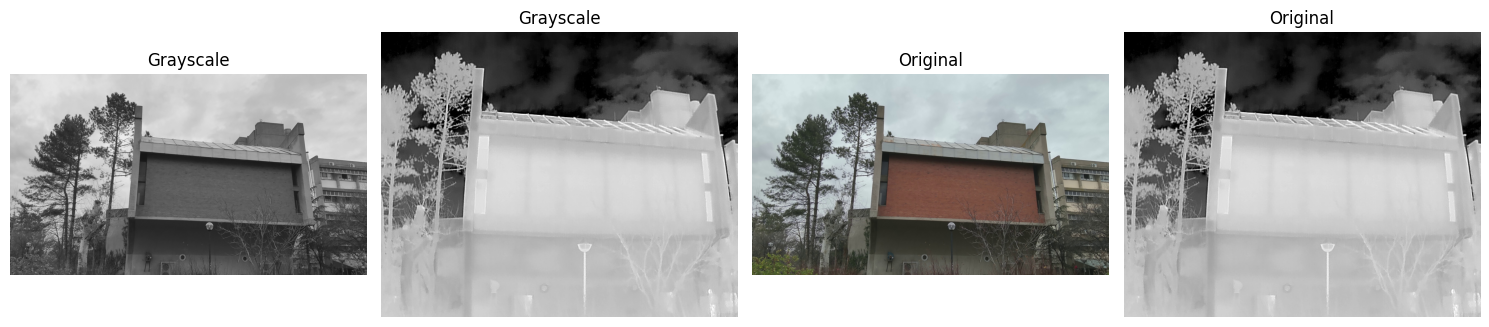

Inspecting augmentations for: IM_01101_cosine


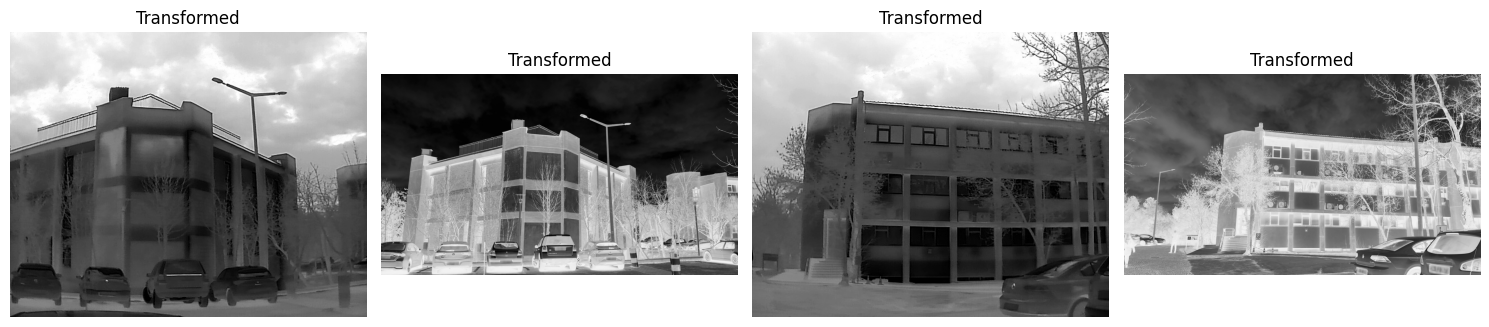

Inspecting augmentations for: IM_02326_cosine


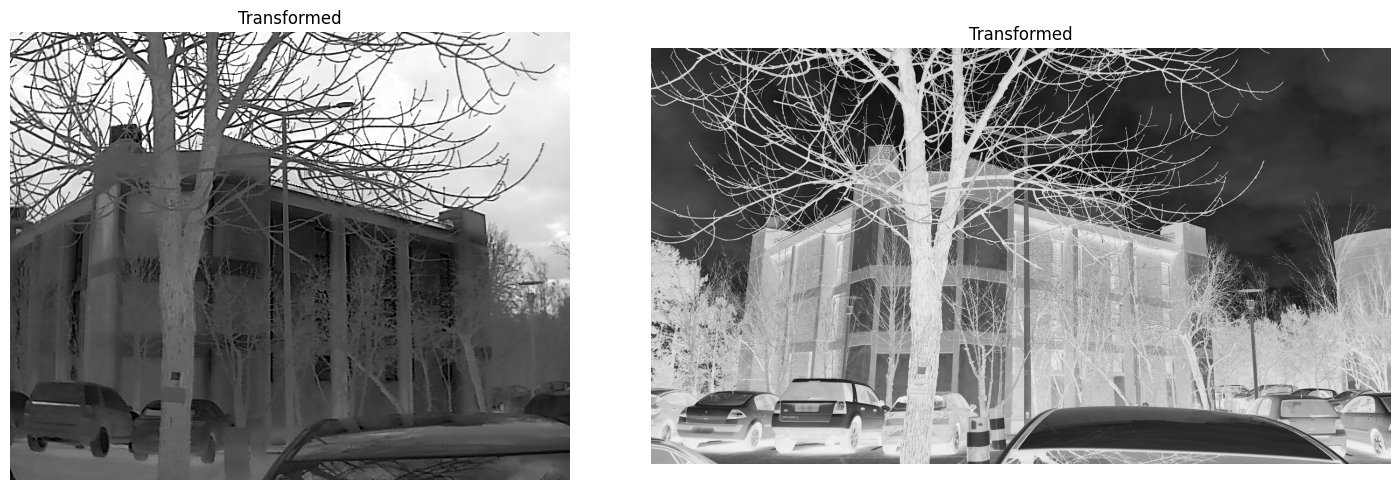

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

def inspect_augmentations(augmented_folder, num_samples=5):
    """
    Visually inspect augmented images by displaying a few examples with their augmentations.

    Args:
        augmented_folder (str): Path to the folder containing augmented images.
        num_samples (int): Number of random samples to inspect.
    """
    # Recursively collect all augmented images
    all_files = []
    for root, _, files in os.walk(augmented_folder):
        all_files.extend([os.path.join(root, f) for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])

    if not all_files:
        print(f"No augmented images found in the folder: {augmented_folder}")
        return

    # Group images by their base name
    augmentation_dict = {}
    for file in all_files:
        base_name = "_".join(os.path.basename(file).split("_")[:-1])  # Extract the base name
        if base_name not in augmentation_dict:
            augmentation_dict[base_name] = []
        augmentation_dict[base_name].append(file)

    # Select random samples for inspection
    inspected_samples = list(augmentation_dict.keys())
    if len(inspected_samples) > num_samples:
        inspected_samples = random.sample(inspected_samples, num_samples)

    for base_name in inspected_samples:
        print(f"Inspecting augmentations for: {base_name}")
        augmented_images = augmentation_dict[base_name]

        # Sort by augmentation type for consistent visualization
        augmented_images.sort(key=lambda x: os.path.basename(x).split("_")[-1])

        # Display the original and augmented images
        plt.figure(figsize=(15, 5))
        for i, img_path in enumerate(augmented_images):
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get augmentation label
            aug_label = os.path.basename(img_path).split("_")[-1].split(".")[0]

            plt.subplot(1, len(augmented_images), i + 1)
            plt.imshow(img, cmap="gray" if len(img.shape) == 2 else None)
            plt.title(aug_label.replace("_", " ").capitalize())
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Example usage
augmented_folder = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"
inspect_augmentations(augmented_folder, num_samples=3)

#### Splitting Data into Train-Test-Val

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def safe_split(data, train_ratio=0.7, val_ratio=0.15):
    """
    Splits data safely into train, validation, and test lists.
    If there are too few items, then the splitting is adjusted.
    """
    if len(data) < 2:
        return data, [], []  # If there's only one pair, keep it all in training
    elif len(data) < 4:
        train_files, test_files = train_test_split(data, test_size=0.5, random_state=42)
        return train_files, test_files, []  # No validation set if fewer than 4 pairs
    else:
        train_files, temp_files = train_test_split(data, test_size=(1 - train_ratio), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
        return train_files, val_files, test_files

def create_folders(base_dir, sub_dirs):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    for sub_dir in sub_dirs:
        path = os.path.join(base_dir, sub_dir)
        if not os.path.exists(path):
            os.makedirs(path)

def split_dataset_pairs(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Splits the dataset ensuring that each matching pair of thermal and visible images
    (matched by filename) is kept together in the same split.

    Expected directory structure:
      source_dir/
          condition/          (e.g., cloudy, sunny, etc.)
              scene/         (e.g., scene_1, scene_2, etc.)
                  thermal/   (or thermal/images/ if nested)
                  visible/   (or visible/images/ if nested)
    """
    # Convert paths to absolute paths for reliable comparisons.
    abs_source = os.path.abspath(source_dir)
    abs_output = os.path.abspath(output_dir)

    # Check: The output directory should not be inside the source directory.
    if abs_output.startswith(abs_source + os.sep):
        raise ValueError("The output directory should not be inside the source directory to avoid reprocessing copied files.")

    # Create top-level output folders for train, val, test
    create_folders(output_dir, ['train', 'val', 'test'])
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    # Loop through conditions, and skip folders that are likely output folders.
    for condition in os.listdir(source_dir):
        if condition in ['train', 'val', 'test']:
            continue  # Skip potential output directories if present in the source.
        condition_path = os.path.join(source_dir, condition)
        if not os.path.isdir(condition_path):
            continue

        for scene in os.listdir(condition_path):
            scene_path = os.path.join(condition_path, scene)
            if not os.path.isdir(scene_path):
                continue

            # Set paths for the two modalities
            thermal_path = os.path.join(scene_path, "thermal")
            visible_path = os.path.join(scene_path, "visible")

            # Check that both modality folders exist
            if not os.path.isdir(thermal_path) or not os.path.isdir(visible_path):
                print(f"Skipping scene '{scene_path}' because one modality folder is missing.")
                continue

            # If images are nested in a subfolder (e.g., "images"), update the paths.
            if os.path.isdir(os.path.join(thermal_path, "images")):
                thermal_path = os.path.join(thermal_path, "images")
            if os.path.isdir(os.path.join(visible_path, "images")):
                visible_path = os.path.join(visible_path, "images")

            # List image files in each modality folder
            thermal_files = [f for f in os.listdir(thermal_path)
                             if os.path.isfile(os.path.join(thermal_path, f))]
            visible_files = [f for f in os.listdir(visible_path)
                             if os.path.isfile(os.path.join(visible_path, f))]

            # Find matching pairs by filename intersection
            pairs = sorted(list(set(thermal_files) & set(visible_files)))
            if not pairs:
                print(f"No matching pairs found in scene '{scene_path}'.")
                continue

            # Split the pairs into train, validation, and test sets
            train_pairs, val_pairs, test_pairs = safe_split(pairs, train_ratio, val_ratio)

            # Copy the pairs to the respective split directories.
            # We are flattening the folder structure by modality.
            for split_dir, split_pairs in zip([train_dir, val_dir, test_dir],
                                              [train_pairs, val_pairs, test_pairs]):
                if split_pairs:
                    # Create destination subdirectories for each modality if they do not exist
                    dest_thermal = os.path.join(split_dir, "thermal")
                    dest_visible = os.path.join(split_dir, "visible")
                    os.makedirs(dest_thermal, exist_ok=True)
                    os.makedirs(dest_visible, exist_ok=True)

                    for file in split_pairs:
                        src_thermal = os.path.join(thermal_path, file)
                        dst_thermal = os.path.join(dest_thermal, file)
                        shutil.copy(src_thermal, dst_thermal)

                        src_visible = os.path.join(visible_path, file)
                        dst_visible = os.path.join(dest_visible, file)
                        shutil.copy(src_visible, dst_visible)

    print(f"Dataset successfully split into train ({train_ratio*100}%), "
          f"val ({val_ratio*100}%), and test ({test_ratio*100}%) sets.")

# Example usage:
# split_dataset_pairs("path/to/source", "path/to/output")


In [ ]:
"""
# Example Usage
source_dataset_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"
output_dataset_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted"

# Ensure source dataset exists for demonstration purposes
if not os.path.exists(source_dataset_path):
    os.makedirs(source_dataset_path)
    print(f"Created example source dataset folder at {source_dataset_path}")

# Run dataset split
split_dataset_pairs(source_dataset_path, output_dataset_path)"""

'\n# Example Usage\nsource_dataset_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Augmented"\noutput_dataset_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted"\n\n# Ensure source dataset exists for demonstration purposes\nif not os.path.exists(source_dataset_path):\n    os.makedirs(source_dataset_path)\n    print(f"Created example source dataset folder at {source_dataset_path}")\n\n# Run dataset split\nsplit_dataset_pairs(source_dataset_path, output_dataset_path)'

Code to see dataset sizes

In [ ]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            if os.path.isfile(file_path):
                total_size += os.path.getsize(file_path)
    return total_size

# Replace with your actual folder path
folder_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted"
size_in_bytes = get_folder_size(folder_path)
size_in_gb = size_in_bytes / (1024**3)

print(f"Total size of '{folder_path}': {size_in_gb:.2f} GB")

Total size of '/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted': 15.63 GB


## Our Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model
import torch.quantization as quant

### SuperPoint & SuperGlue

#### SuperPoint Backbone

In [ ]:
%cd /content
!rm -rf /content/SuperGluePretrainedNetwork
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork
%cd /content/SuperGluePretrainedNetwork


/content
Cloning into 'SuperGluePretrainedNetwork'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 184 (from 2)
Receiving objects: 100% (185/185), 118.85 MiB | 20.50 MiB/s, done.
Resolving deltas: 100% (52/52), done.
/content/SuperGluePretrainedNetwork


In [ ]:
sys.path.insert(0, "/content/SuperGluePretrainedNetwork")
from models.superpoint import SuperPoint
from torchvision import transforms
import torch
import torch.nn.functional as F

class SuperPointExtractor(nn.Module):
    def __init__(self, debug: bool = False):
        super(SuperPointExtractor, self).__init__()
        self.orb = cv2.ORB_create()
        self.debug = debug
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.sp_config = {
            'nms_radius': 4,
            'keypoint_threshold': 0.005,
            'max_keypoints': 1024
        }
        self.SuperPoint = SuperPoint(self.sp_config).eval().to(self.device)
        if self.debug:
            print("[DEBUG] SuperPointExtractor initialized.")


    def extract_keypoints(self, images, debug: bool = False):
        """
        Expects images to be of shape [B, C, H, W] and returns:
          keypoints: [B, max_N, 2],
          descriptors: [B, 256, max_N],
          scores: [B, max_N],
          valid_mask: [B, max_N] (Boolean mask indicating valid keypoints)
        """
        keypoints_list, descriptors_list, scores_list = [], [], []
        B = images.shape[0]
        for b in range(B):
            image = images[b]  # shape: [C, H, W]
            # Convert RGB to grayscale if needed
            if image.shape[0] == 3:
                # Standard luminance conversion
                grayscale = 0.2989 * image[0:1] + 0.5870 * image[1:2] + 0.1140 * image[2:3]
            else:
                grayscale = image
            # Add a batch dimension for the SuperPoint model
            output = self.SuperPoint({'image': grayscale.unsqueeze(0)})
            keypoints_list.append(output['keypoints'][0])       # shape: [num_keypoints, 2]
            descriptors_list.append(output['descriptors'][0])   # shape: [256, num_keypoints]
            scores_list.append(output['scores'][0])             # shape: [num_keypoints]

        # Determine the maximum number of keypoints in this batch
        max_kpts = max(kpts.shape[0] for kpts in keypoints_list)

        padded_keypoints = []
        padded_descriptors = []
        padded_scores = []
        valid_masks = []  # To mark valid keypoints (1 for valid, 0 for padded)

        for kpts, desc, scr in zip(keypoints_list, descriptors_list, scores_list):
            num = kpts.shape[0]
            pad_size = max_kpts - num
            # Pad keypoints: pad last dimension (only need to pad keypoints along dim=0)
            if pad_size > 0:
                kpts_pad = F.pad(kpts, (0, 0, 0, pad_size), value=0)
                desc_pad = F.pad(desc, (0, pad_size), value=0)
                scr_pad = F.pad(scr, (0, pad_size), value=0)
                mask = torch.cat([torch.ones(num, dtype=torch.bool, device=kpts.device),
                                  torch.zeros(pad_size, dtype=torch.bool, device=kpts.device)], dim=0)
            else:
                kpts_pad = kpts
                desc_pad = desc
                scr_pad = scr
                mask = torch.ones(num, dtype=torch.bool, device=kpts.device)
            padded_keypoints.append(kpts_pad)
            padded_descriptors.append(desc_pad)
            padded_scores.append(scr_pad)
            valid_masks.append(mask)

        # Stack along a new batch dimension:
        keypoints = torch.stack(padded_keypoints, dim=0)       # [B, max_N, 2]
        descriptors = torch.stack(padded_descriptors, dim=0)   # [B, 256, max_N]
        scores = torch.stack(padded_scores, dim=0)             # [B, max_N]
        valid_mask = torch.stack(valid_masks, dim=0)           # [B, max_N]

        if debug:
            print(f"[DEBUG] Extracted keypoints for {B} images, max keypoints: {max_kpts}.")
        return keypoints, descriptors, scores, valid_mask



#### Feature Matching with SuperGlue

In [ ]:
import sys
import os
print(os.getcwd())  # Print the current working directory

/content/SuperGluePretrainedNetwork


In [ ]:
import torch
sys.path.insert(0, "/content/SuperGluePretrainedNetwork")
from models.superglue import SuperGlue

# Define your custom configuration (optional)
config = {
    'descriptor_dim': 256,  # Dimension of the feature descriptor
    'weights': 'outdoor',  # or 'outdoor'
    'keypoint_encoder': [32, 64, 128, 256],
    'GNN_layers': ['self', 'cross'] * 9,
    'sinkhorn_iterations': 100,
    'match_threshold': 0.2,
}

#from models.superglue import SuperGlue
#from models.utils import read_image, draw_matches

# Load the pre-trained SuperGlue model
model = SuperGlue(config)


Loaded SuperGlue model ("outdoor" weights)


### Loss Function

 Third iteration for the loss function, Nan and Inf prevention for all

In [ ]:
# ===== Cell 1: Loss Functions & Homography Utilities =====
import torch
import torch.nn.functional as F
import kornia as K    # for DLT-based estimation

# Normalize homography so H[...,2,2] == 1
# Normalize and losses
import torch
import torch.nn.functional as F
import kornia as K

# ----- Homography & Reprojection Utilities -----

# ----- Homography & Reprojection Utilities -----

import torch
import torch.nn.functional as F
import kornia as K
import cv2
import numpy as np

# ----- Homography & Reprojection Utilities -----

def normalize_homography(H: torch.Tensor) -> torch.Tensor:
    return H / (H[..., 2:3, 2:3] + 1e-8)

def homography_matrix_loss(
    H_pred: torch.Tensor,
    H_gt: torch.Tensor,
    reduction: str = 'mean'
) -> torch.Tensor:
    H_pred = normalize_homography(H_pred)
    H_gt   = normalize_homography(H_gt)
    return F.smooth_l1_loss(H_pred, H_gt, reduction=reduction)

def reprojection_loss(
    k0: torch.Tensor,
    k1: torch.Tensor,
    H: torch.Tensor,
    mask: torch.Tensor
) -> torch.Tensor:
    # compute in float32 for stability
    k0_f = k0.float()
    k1_f = k1.float()
    H_f  = H.float()
    ones = torch.ones_like(k0_f[..., :1])
    x0h  = torch.cat([k0_f, ones], dim=-1)
    x1h  = (H_f @ x0h.transpose(1,2)).transpose(1,2)
    x1   = x1h[..., :2] / (x1h[..., 2:3] + 1e-8)
    err  = (x1 - k1_f).norm(dim=-1) * mask.float()
    loss = err.sum() / (mask.float().sum() + 1e-8)
    # clamp NaNs and infinities
    return torch.nan_to_num(loss, nan=0.0, posinf=0.0, neginf=0.0)

def estimate_homography_batch(k0, k1, mask):
    B, _, _ = k0.shape
    H_out = []
    for bi in range(B):
        m = mask[bi]
        if m.sum() < 4:
            H_out.append(torch.eye(3, device=k0.device, dtype=k0.dtype))
            continue
        src_pts = k0[bi, m].detach().cpu().numpy().reshape(-1,1,2)
        dst_pts = k1[bi, m].detach().cpu().numpy().reshape(-1,1,2)
        H_np, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
        H_b = torch.from_numpy((H_np if H_np is not None else np.eye(3, np.float32))).to(k0.device)
        H_out.append(H_b.to(k0.dtype))
    return torch.stack(H_out, dim=0)

def soft_contrastive_loss(predicted, ground_truth, confidence, eps=1e-8):
    # 1) Clamp into (0,1) to avoid log(0)
    p = predicted.clamp(min=eps, max=1 - eps)

    # 2) Convert probabilities -> logits
    logits = torch.log(p / (1 - p))

    # 3) Build weight mask
    w = confidence * ground_truth + (1 - confidence) * (1 - ground_truth)

    # 4) Autocast‐safe BCE with logits
    loss = F.binary_cross_entropy_with_logits(logits, ground_truth, weight=w, reduction='mean')
    return loss

def sub_pixel_consistency_loss(matches: dict,
                               mask: torch.Tensor | None = None) -> torch.Tensor:
    k0  = matches["keypoints0"].float()
    k1  = matches["keypoints1"].float()
    rk0 = matches["refined_keypoints0"].float()
    rk1 = matches["refined_keypoints1"].float()

    if mask is not None:
        m = mask.unsqueeze(-1)   # [B,N,1]
        k0,  rk0 = k0*m,  rk0*m
        k1,  rk1 = k1*m,  rk1*m

    rk0 = torch.nan_to_num(rk0, nan=0.0, posinf=0.0, neginf=0.0)
    rk1 = torch.nan_to_num(rk1, nan=0.0, posinf=0.0, neginf=0.0)

    loss0 = F.smooth_l1_loss(rk0, k0, reduction='mean')
    loss1 = F.smooth_l1_loss(rk1, k1, reduction='mean')
    return (loss0 + loss1) * 0.05

In [ ]:
import torch.nn.functional as Fun
import torch

def compute_similarity(descriptors0, descriptors1):
    """
    Computes cosine similarity between descriptors from two images.

    Args:
        descriptors0 (Tensor): Shape [B, 256, N].
        descriptors1 (Tensor): Shape [B, 256, N].

    Returns:
        Tensor: similarity matrix of shape [B, N, N].
    """
    d0 = F.normalize(descriptors0, p=2, dim=1)
    d1 = F.normalize(descriptors1, p=2, dim=1)
    sim_matrix = torch.bmm(d0.transpose(1,2), d1)
    return sim_matrix

#### homo loss testing

In [ ]:
# ─── 1) Imports & Homography Utilities ─────────────────────────────────────
import os, glob, cv2, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

extractor = SuperPointExtractor()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── 2) Dataset ─────────────────────────────────────────────────────────────
class ThermalHomographyDataset(Dataset):
    def __init__(self, rgb_dir, thermal_dir, homography_dir, img_size=(640,480)):
        self.rgb_dir, self.th_dir, self.h_dir = rgb_dir, thermal_dir, homography_dir
        exts = ('*.jpg','*.png','*.jpeg','*.tif','*.bmp')
        self.files = sorted(sum([glob.glob(os.path.join(rgb_dir, e)) for e in exts], []))
        self.img_size = img_size
    @staticmethod
    def _robust_load_H(path):
        try:
            arr = np.loadtxt(path, dtype=np.float32)
        except:
            return np.eye(3, dtype=np.float32)
        if arr.shape == (3,3): return arr
        if arr.ndim==1 and arr.size==9: return arr.reshape(3,3)
        if arr.ndim==2 and arr.shape[1]==4 and len(arr)>=4:
            src, dst = arr[:,:2].reshape(-1,1,2), arr[:,2:].reshape(-1,1,2)
            H,_ = cv2.findHomography(src, dst, cv2.RANSAC)
            return (H if H is not None else np.eye(3, dtype=np.float32)).astype(np.float32)
        return np.eye(3, dtype=np.float32)
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        rgb_path = self.files[idx]
        fname    = os.path.basename(rgb_path)
        thr_path = os.path.join(self.th_dir, fname)
        rgb = cv2.cvtColor(cv2.imread(rgb_path), cv2.COLOR_BGR2RGB)
        thr = cv2.cvtColor(cv2.imread(thr_path), cv2.COLOR_BGR2RGB)
        rgb = cv2.resize(rgb, self.img_size)
        thr = cv2.resize(thr, self.img_size)
        rgb_t = torch.from_numpy(rgb).permute(2,0,1).float()/255.
        thr_t = torch.from_numpy(thr).permute(2,0,1).float()/255.
        # load H
        base = os.path.splitext(fname)[0]
        txt  = os.path.join(self.h_dir, base + ".txt")
        H    = self._robust_load_H(txt)
        hasH = True
        return rgb_t, thr_t, torch.from_numpy(H), torch.tensor([hasH], dtype=torch.bool)


# ─── 4) Build test loader ─────────────────────────────────────────────────

RGB_DIR       = "/content/drive/MyDrive/ThermalNet/small_dataset/rgb"
TH_DIR   = "/content/drive/MyDrive/ThermalNet/small_dataset/thermal"
H_DIR= "/content/drive/MyDrive/ThermalNet/small_dataset/homography_matrix"
test_ds   = ThermalHomographyDataset(RGB_DIR, TH_DIR, H_DIR)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# ─── 5) Run evaluation ─────────────────────────────────────────────────────
mat_losses, reproj_losses = [], []
with torch.no_grad():
    for rgb, thr, H_gt, has_H in test_loader:
        rgb, thr = rgb.to(device), thr.to(device)
        H_gt     = H_gt.to(device).float()
        has_H    = has_H.to(device).squeeze(-1)

        # 5a) convert to grayscale & extract features via the correct method
        rgb_gray = (0.2989 * rgb[:,0:1] + 0.5870 * rgb[:,1:2] + 0.1140 * rgb[:,2:3])
        thr_gray = (0.2989 * thr[:,0:1] + 0.5870 * thr[:,1:2] + 0.1140 * thr[:,2:3])
        k0, d0, s0, m0 = extractor.extract_keypoints(rgb_gray)
        k1, d1, s1, m1 = extractor.extract_keypoints(thr_gray)

        # 5b) match
        inp = {
          'image0': rgb_gray,       # single-channel image tensor [B,1,H,W]
          'image1': thr_gray,       # same for thermal
          'keypoints0': k0,         # [B, N, 2]
          'descriptors0': d0,       # [B, 256, N]
          'scores0': s0,            # [B, N]
          'keypoints1': k1,         # [B, N, 2]
          'descriptors1': d1,       # [B, 256, N]
          'scores1': s1             # [B, N]
        }

        out = matcher(inp)

        # 5c) build mask & crop
        mask = out.get('mask0')
        if mask is None:
            N = d0.shape[2]
            mask = torch.ones(1, N, device=device, dtype=torch.bool)
        else:
            mask = mask.bool()
        L = min(mask.shape[1], d0.shape[2], d1.shape[2])
        mask = mask[:, :L]
        k0, k1 = k0[:, :L], k1[:, :L]

        # 5d) estimate H_pred
        H_pred = estimate_homography_batch(k0, k1, mask)

        # 5e) compute losses if GT present
        if has_H.item():
            ml = homography_matrix_loss(H_pred, H_gt).item()
            rl = reprojection_loss(k0, k1, H_pred, mask).item()
        else:
            ml, rl = float('nan'), float('nan')

        mat_losses.append(ml)
        reproj_losses.append(rl)

# filter NaNs & report
mat_losses    = [x for x in mat_losses if not np.isnan(x)]
reproj_losses = [x for x in reproj_losses if not np.isnan(x)]
print(f"Mean matrix loss:   {np.mean(mat_losses):.4f}")
print(f"Mean reproj loss:   {np.mean(reproj_losses):.4f}")

Loaded SuperPoint model


NameError: name 'matcher' is not defined

### Sub-pixel Refinement Module

RAFT

In [ ]:
%cd /content
!rm -rf RAFT  # Remove the existing directory
!git clone https://github.com/princeton-vl/RAFT.git
%cd RAFT
!chmod +x download_models.sh
!./download_models.sh


/content
Cloning into 'RAFT'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 147 (delta 0), reused 0 (delta 0), pack-reused 146 (from 2)
Receiving objects: 100% (147/147), 10.01 MiB | 18.58 MiB/s, done.
Resolving deltas: 100% (57/57), done.
/content/RAFT
--2025-05-01 15:18:44--  https://dl.dropboxusercontent.com/s/4j4z58wuv8o0mfz/models.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.80.15, 2620:100:6035:15::a27d:550f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.80.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81977417 (78M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]  78.18M  23.6MB/s    in 3.3s    

2025-05-01 15:18:49 (23.6 MB/s) - ‘models.zip’ saved [81977417/81977417]

Archive:  models.zip
   creating: models/
  inflating: models/raft-kitti.pth   
  inflating: models/raft-sintel.pth  
  infla

In [ ]:
import sys
sys.path.append("/content/RAFT")

In [ ]:
!ls /content/RAFT/core

corr.py  datasets.py  extractor.py  __init__.py  raft.py  update.py  utils


In [ ]:
import argparse
#normal args
# Create a dummy args object
args = argparse.Namespace()
args.small = False                # or True, depending on which version you want
args.corr_levels = 4
args.corr_radius = 4
args.dropout = 0
args.alternate_corr = False
args.mixed_precision = False

In [ ]:
import torch
import torch.nn as nn
sys.path.append("/content/RAFT/core")
from raft import RAFT
import argparse

class SubPixelRefinementWithFlow(nn.Module):
    def __init__(self):
        super(SubPixelRefinementWithFlow, self).__init__()
        self.optical_flow = RAFT(args)
        #freeze all layers
        for param in self.optical_flow.parameters():
            param.requires_grad = False
        #unfreeze gru layers only
        for name, param in self.optical_flow.named_parameters():
            if "update_block.gru" in name:
                param.requires_grad = True


    def forward(self, image0, image1, initial_matches):
        """
        Refines the initial matches using optical flow.

        Args:
            image0 (torch.Tensor): The first image (batch_size, channels, height, width)
            image1 (torch.Tensor): The second image (batch_size, channels, height, width)
            initial_matches (dict): The initial matches from the feature matching module.

        Returns:
            refined_matches (dict): The refined matches after optical flow refinement.
        """
        # The `initial_matches` dictionary typically contains the keypoints and their initial matching confidence.
        # We will assume it contains 'keypoints0' and 'keypoints1', which are the coordinates of matched points.
        B, C, H, W = image0.shape
        self.H = H
        self.W = W

        keypoints0 = initial_matches['keypoints0']  # Extract initial keypoints from the match data
        keypoints1 = initial_matches['keypoints1']
        # We'll use the final flow, so we call it with test_mode=True:
        _, flow_up = self.optical_flow(image0, image1, test_mode=True)
        # Now flow_up should have shape [B, 2, H, W] with H and W equal to self.H, self.W

        # Sample the flow at keypoint locations:
        sampled_flow0 = sample_flow(flow_up, keypoints0, self.H, self.W)
        sampled_flow1 = sample_flow(flow_up, keypoints1, self.H, self.W)


        # Apply the flow to refine the keypoints in both images
        refined_keypoints0 = keypoints0 + sampled_flow0
        refined_keypoints1 = keypoints1 + sampled_flow1

        refined_matches = {
            'refined_keypoints0': refined_keypoints0,
            'refined_keypoints1': refined_keypoints1,
            'confidence': initial_matches.get('confidence', None),
        }

        return refined_matches


def sample_flow(flow, keypoints, H, W):
        """
        Samples the flow at given keypoint locations.

        Args:
            flow (Tensor): Flow tensor of shape [B, 2, H, W].
            keypoints (Tensor): Keypoint tensor of shape [B, N, 2] in pixel coordinates.
            H (int): Height of the flow field.
            W (int): Width of the flow field.

        Returns:
            Tensor: Sampled flow at keypoint locations, shape [B, N, 2].
        """
        B, _, H_f, W_f = flow.shape  # Extract batch size and dimensions
        B_k, N, _ = keypoints.shape  # Extract batch size of keypoints

        # Normalize keypoints to [-1, 1] for grid_sample()
        kp_norm = torch.stack([(keypoints[..., 0] / (W - 1)) * 2 - 1,
                              (keypoints[..., 1] / (H - 1)) * 2 - 1], dim=-1)  # [B, N, 2]

        # Ensure keypoints have correct shape for grid_sample: [B, N, 1, 2]
        grid = kp_norm.unsqueeze(2)

        # **Fix batch size mismatch**
        if B_k != B:
            grid = grid.expand(B, -1, -1, -1)  # Expand grid to match flow batch size


        # Use grid_sample to sample the flow at the keypoint locations
        sampled = F.grid_sample(flow, grid, align_corners=True)  # [B, 2, N, 1]
        sampled = sampled.squeeze(-1).permute(0, 2, 1)  # [B, N, 2]
        return sampled


In [ ]:
raft = RAFT(args)
for name, param in raft.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Trainable: fnet.conv1.weight
Trainable: fnet.conv1.bias
Trainable: fnet.layer1.0.conv1.weight
Trainable: fnet.layer1.0.conv1.bias
Trainable: fnet.layer1.0.conv2.weight
Trainable: fnet.layer1.0.conv2.bias
Trainable: fnet.layer1.1.conv1.weight
Trainable: fnet.layer1.1.conv1.bias
Trainable: fnet.layer1.1.conv2.weight
Trainable: fnet.layer1.1.conv2.bias
Trainable: fnet.layer2.0.conv1.weight
Trainable: fnet.layer2.0.conv1.bias
Trainable: fnet.layer2.0.conv2.weight
Trainable: fnet.layer2.0.conv2.bias
Trainable: fnet.layer2.0.downsample.0.weight
Trainable: fnet.layer2.0.downsample.0.bias
Trainable: fnet.layer2.1.conv1.weight
Trainable: fnet.layer2.1.conv1.bias
Trainable: fnet.layer2.1.conv2.weight
Trainable: fnet.layer2.1.conv2.bias
Trainable: fnet.layer3.0.conv1.weight
Trainable: fnet.layer3.0.conv1.bias
Trainable: fnet.layer3.0.conv2.weight
Trainable: fnet.layer3.0.conv2.bias
Trainable: fnet.layer3.0.downsample.0.weight
Trainable: fnet.layer3.0.downsample.0.bias
Trainable: fnet.layer3.1.con

### Scale-Aware Matching

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ScaleAwareMatching(nn.Module):
    def __init__(self, scales=[0.5, 0.75, 1.0, 1.5, 2.0], distance_threshold=5.0):
        super(ScaleAwareMatching, self).__init__()
        self.scales = scales
        self.distance_threshold = distance_threshold

    def forward(self, image0, image1, keypoints0, keypoints1, matches):
        """
        image0, image1: tensors of shape [B, C, H, W]
        keypoints0, keypoints1: tensors of shape [B, N, 2] (in feature-map coordinates)
        matches: dictionary containing 'matches0' of shape [B, N] (each value is an index in keypoints1 or -1)
        Returns:
            refined_matches: dict with keys 'matches0', 'matches1', and optionally updated scores.
        """
        device = image0.device
        # We will accumulate valid match indices in lists per batch
        B, N, _ = keypoints0.shape
        refined_matches0 = [[] for _ in range(B)]
        refined_matches1 = [[] for _ in range(B)]

        # For each scale, check the consistency of each match:
        for scale in self.scales:
            # Scale images if needed. (You might not need to use the scaled images if you only use the keypoints.)
            scaled_keypoints0 = keypoints0 * scale  # shape: [B, N, 2]
            scaled_keypoints1 = keypoints1 * scale

            # Loop over batches and matches (using Python loops is acceptable if N is moderate)
            for b in range(B):
                # Get coarse matches for batch b: a tensor of shape [N]
                coarse_matches_b = matches['matches0'][b]  # e.g. indices into keypoints1, or -1 if no match
                for i in range(N):
                    match_idx = coarse_matches_b[i].item()
                    if match_idx == -1:
                        continue  # skip unmatched
                    # Get the scaled keypoints for batch b
                    pt0 = scaled_keypoints0[b, i]  # shape: [2]
                    # Here, make sure match_idx is within bounds.
                    if match_idx < 0 or match_idx >= scaled_keypoints1.shape[1]:
                        continue
                    pt1 = scaled_keypoints1[b, match_idx]
                    # Compute Euclidean distance
                    distance = torch.norm(pt0 - pt1)
                    # If the distance is below the threshold, consider this match valid at this scale.
                    if distance < self.distance_threshold:
                        # Append or update the match. For simplicity, we add the match index from keypoints0 and keypoints1.
                        refined_matches0[b].append(i)
                        refined_matches1[b].append(match_idx)

        # For each batch, if there are no valid matches, set to -1 (or handle as you wish)
        for b in range(B):
            if len(refined_matches0[b]) == 0:
                refined_matches0[b] = [-1]
                refined_matches1[b] = [-1]
            else:
                refined_matches0[b] = torch.tensor(refined_matches0[b], dtype=torch.long, device=device)
                refined_matches1[b] = torch.tensor(refined_matches1[b], dtype=torch.long, device=device)

        # Optionally, you can try to update matching scores based on your criteria.
        # For example, use the original matching scores for the valid indices.
        # Here we simply pass them through.
        refined_scores0 = matches.get("matching_scores0", None)
        refined_scores1 = matches.get("matching_scores1", None)

        # Build a refined matches dictionary.
        refined_matches = {
            "matches0": refined_matches0,  # list of tensors per batch
            "matches1": refined_matches1,
            "scores0": refined_scores0,  # you could also index these per batch if needed
            "scores1": refined_scores1,
        }
        return refined_matches

### Model

In [ ]:
from models.superglue import MLP, SuperGlue
import torch
import torch.nn as nn

class KeypointEncoder(nn.Module):
    def __init__(self, channels, do_bn=True):
        """
        channels: a list defining the MLP layers, e.g. [3, 32, 64, 128, 256].
        do_bn: whether to use batch normalization.
        """
        super(KeypointEncoder, self).__init__()
        self.mlp = MLP(channels, do_bn=do_bn)

    def forward(self, kpts, scores):
        """
        kpts: Tensor of shape [B, N, 2]
        scores: Tensor of shape [B, N]

        Concatenate keypoints and scores to form an input of shape [B, N, 3],
        then transpose to [B, 3, N] (to match Conv1d input requirements),
        apply the MLP, and return the output in shape [B, 256, N].
        """
        # Concatenate to shape [B, N, 3]
        x = torch.cat([kpts, scores.unsqueeze(-1)], dim=-1)
        # Transpose to [B, 3, N] for the Conv1d layers inside the MLP.
        x = x.transpose(1, 2)
        device = next(self.mlp.parameters()).device
        x = x.to(device)
        # The MLP outputs a tensor of shape [B, 256, N].
        x = self.mlp(x)
        return x




In [ ]:
class HybridModel_SG(nn.Module):
    def __init__(self, matching_type="superglue", debug_backbone=False, scale_aware=True):
        super(HybridModel_SG, self).__init__()

        # Step 1: Backbone
        self.backbone = SuperPointExtractor(debug=debug_backbone)

        if matching_type == "superglue":
            #from SuperGluePretrainedNetwork.models.superglue import SuperGlue, KeypointEncoder
            # Override keypoint encoder so that it exactly matches the "outdoor" pretrained weights.
            # The pretrained weights expect an MLP with layers: input dimension 3, then 32, 64, 128, and finally 256.
            self.matcher = SuperGlue({
                "weights": "outdoor",
                "keypoint_encoder": [32, 64, 128, 256]
            })
            # Override the keypoint encoder to ensure it outputs 256-d.
            self.matcher.kenc = KeypointEncoder(channels=[3, 32, 64, 128, 256], do_bn=True)
            #Freezing the superglue layers
            for param in self.matcher.parameters():
                param.requires_grad = False
            # Unfreeze keypoint encoder
            for param in self.matcher.kenc.parameters():
                param.requires_grad = True
            #unfreeze the final projection layer
            for param in self.matcher.final_proj.parameters():
                param.requires_grad = True

        else:
            raise ValueError("Unsupported matching type. Choose 'loftr' or 'superglue'.")

        # Step 4: Sub-Pixel Refinement with Optical Flow
        self.sub_pixel_refinement = SubPixelRefinementWithFlow()

        # Step 5: Scale-Aware Matching (optional)
        if scale_aware:
            self.scale_aware_matching = ScaleAwareMatching()


    def forward(self, image0, image1):
        device = image0.device
        batch_size = image0.shape[0]

        image0 = image0.to(device)
        image1 = image1.to(device)

        keypoints0, descriptors0, scores0, mask0 = self.backbone.extract_keypoints(image0)
        keypoints1, descriptors1, scores1, mask1 = self.backbone.extract_keypoints(image1)


        # Ensure the number of keypoints and descriptors match
        N = keypoints0.shape[1]

        # (If needed, slice the tensors to ensure they have exactly N keypoints.)
        # For example:
        # keypoints0 = keypoints0[:, :N, :]
        # descriptors0 = descriptors0[:, :, :N]
        # scores0 = scores0[:, :N]
        # (and similarly for image1)

        #desc0 = self.descriptor_proj(desc0)  # [N, 256]
        #desc1 = self.descriptor_proj(desc1)

        self.matcher = self.matcher.to(device)
        # Prepare the data dictionary for SuperGlue.
        data = {
            "image0": image0,
            "image1": image1,
            "keypoints0": keypoints0,      # shape: [B, 1000, 2]
            "keypoints1": keypoints1,      # shape: [B, 1000, 2]
            "descriptors0": descriptors0,  # shape: [B, 256, 1000]
            "descriptors1": descriptors1,  # shape: [B, 256, 1000]
            "scores0": scores0,           # shape: [B, 1000]
            "scores1": scores1,            # shape: [B, 1000]
            "mask0": mask0,
            "mask1": mask1,
        }


        # Compute matches using SuperGlue.
        matches = self.matcher(data)

          # Update coarse_matches to include keypoints if they are missing:
        if "keypoints0" not in matches:
            matches["keypoints0"] = keypoints0
        if "keypoints1" not in matches:
            matches["keypoints1"] = keypoints1

        if hasattr(self, "scale_aware_matching"):
            refined_matches = self.scale_aware_matching(image0, image1, keypoints0, keypoints1, matches)
        else:
            refined_matches = matches  # Use raw matches if scale-awareness is disabled

        # **Fix:** Add keypoints to refined_matches if missing.
        if "keypoints0" not in refined_matches:
            refined_matches["keypoints0"] = keypoints0
        if "keypoints1" not in refined_matches:
            refined_matches["keypoints1"] = keypoints1

            # Step 3: Apply Sub-Pixel Refinement on the refined matches
        final_matches = self.sub_pixel_refinement(image0, image1, refined_matches)

        # Build output dictionary (example structure)
        output = {
            "refined_keypoints0": final_matches.get("refined_keypoints0", keypoints0),
            "refined_keypoints1": final_matches.get("refined_keypoints1", keypoints1),
            "descriptors0": descriptors0,
            "descriptors1": descriptors1,
            "keypoints0": keypoints0,
            "keypoints1": keypoints1,
            "scores0": scores0,
            "scores1": scores1,
            "coarse_matches": matches,
            "refined_matches": refined_matches,
        }

        return output


In [ ]:
test_matcher = SuperGlue({
                "weights": "outdoor",
                "keypoint_encoder": [32, 64, 128, 256]
            })
for name, param in test_matcher.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")

Loaded SuperGlue model ("outdoor" weights)
Trainable: bin_score
Trainable: kenc.encoder.0.weight
Trainable: kenc.encoder.0.bias
Trainable: kenc.encoder.1.weight
Trainable: kenc.encoder.1.bias
Trainable: kenc.encoder.3.weight
Trainable: kenc.encoder.3.bias
Trainable: kenc.encoder.4.weight
Trainable: kenc.encoder.4.bias
Trainable: kenc.encoder.6.weight
Trainable: kenc.encoder.6.bias
Trainable: kenc.encoder.7.weight
Trainable: kenc.encoder.7.bias
Trainable: kenc.encoder.9.weight
Trainable: kenc.encoder.9.bias
Trainable: kenc.encoder.10.weight
Trainable: kenc.encoder.10.bias
Trainable: kenc.encoder.12.weight
Trainable: kenc.encoder.12.bias
Trainable: gnn.layers.0.attn.merge.weight
Trainable: gnn.layers.0.attn.merge.bias
Trainable: gnn.layers.0.attn.proj.0.weight
Trainable: gnn.layers.0.attn.proj.0.bias
Trainable: gnn.layers.0.attn.proj.1.weight
Trainable: gnn.layers.0.attn.proj.1.bias
Trainable: gnn.layers.0.attn.proj.2.weight
Trainable: gnn.layers.0.attn.proj.2.bias
Trainable: gnn.layers.

## Training

###Dataset Class & Training function


In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
sys.path.append("/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted")

class CustomMatchingDataset(Dataset):
    def __init__(self, data_dir,transform=None):

        """Args:
            data_dir (str): Root directory of your dataset (e.g., "/content/drive/MyDrive/Augmented_Data/test")
            transform (callable, optional): Optional transform to be applied on a sample."""

        # Define paths for label images and original images
        self.label_dir = os.path.join(data_dir, "thermal")
        self.org_dir = os.path.join(data_dir, "visible")

        # List of label image filenames (assumes these filenames contain '_lab')
        self.filenames = sorted(os.listdir(self.label_dir))

        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get label image filename
        label_filename = self.filenames[idx]
        # Extract the base name (e.g., "10163") assuming the label filename is like "10163_lab.png"
        base_name = label_filename.split("_lab")[0]
        org_filename = base_name + ".jpg"  # Construct original image filename

        label_path = os.path.join(self.label_dir, label_filename)
        org_path = os.path.join(self.org_dir, label_filename)

        # Load images using OpenCV
        label_img = cv2.imread(label_path)
        org_img = cv2.imread(org_path)
        if label_img is None or org_img is None:
            raise FileNotFoundError(f"Could not find image for base name {base_name}")

        # Convert images from BGR to RGB (if desired)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)
        org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)

        # Optionally apply transformations (e.g., converting to tensor, normalization, resize)
        if self.transform:
            label_img = self.transform(label_img)
            org_img = self.transform(org_img)
        else:
            # Default transformation: convert to float32 tensor and normalize [0,1]
            # Convert to HWC->CHW and then to torch.Tensor
            label_img = torch.from_numpy(label_img.transpose(2, 0, 1)).float() / 255.0
            org_img = torch.from_numpy(org_img.transpose(2, 0, 1)).float() / 255.0

      # Load real homography from .np
        ground_truth_matches = torch.zeros(1)  # Dummy tensor
        homography_matrix = torch.eye(3)
        # Return a tuple with exactly 4 items: (image0, image1, ground_truth_matches, homography_matrix)
        # Adjust the order if necessary. For example, here I assume image0 is the original image and image1 is the label image.
        return org_img, label_img, ground_truth_matches, homography_matrix



import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class RealHomographyDataset(Dataset):
    def __init__(self, data_dir, homography_dir, transform=None):
        """
        data_dir: root with subfolders 'visible' and 'thermal'.
        homography_dir: folder with .npy files, each storing a 3x3 homography.
        transform: optional transform (resize, etc.).
        """
        self.visible_dir = os.path.join(data_dir, "visible")
        self.thermal_dir = os.path.join(data_dir, "thermal")
        self.transform = transform

        # A list of image filenames that exist in both visible and thermal.
        self.filenames = sorted(os.listdir(self.visible_dir))

        # Match each filename with a corresponding .npy in homography_dir
        self.homography_dir = homography_dir

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        vis_filename = self.filenames[idx]
        therm_filename = vis_filename  # same base name for thermal

        vis_path = os.path.join(self.visible_dir, vis_filename)
        therm_path = os.path.join(self.thermal_dir, therm_filename)

        # Load images
        vis_img = cv2.imread(vis_path)
        therm_img = cv2.imread(therm_path)
        if vis_img is None or therm_img is None:
            raise FileNotFoundError(f"Could not load {vis_path} or {therm_path}.")

        # Convert BGR->RGB if desired
        vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
        therm_img = cv2.cvtColor(therm_img, cv2.COLOR_BGR2RGB)

        # Optional transform
        if self.transform:
            vis_img = self.transform(vis_img)
            therm_img = self.transform(therm_img)
        else:
            vis_img = torch.from_numpy(vis_img.transpose(2,0,1)).float()/255.0
            therm_img = torch.from_numpy(therm_img.transpose(2,0,1)).float()/255.0

        # Load real homography from .npy
        # For example, if filenames are "IM_00006.jpg", we expect "IM_00006.npy" in homography_dir
        base_name = os.path.splitext(vis_filename)[0]  # e.g. "IM_00006"
        H_path = os.path.join(self.homography_dir, base_name + ".npy")
        H = np.load(H_path)  # shape [3,3]
        homography_matrix = torch.from_numpy(H).float()

        # Dummy ground_truth_matches (not used if we rely on geometry alone)
        ground_truth_matches = torch.zeros(1)

        return vis_img, therm_img, ground_truth_matches, homography_matrix


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

import torch.optim as optim
from torch.utils.data import DataLoader

import torch
import torch.optim as optim

# Assuming CustomMatchingDataset is already defined
dataset_path = "/content/drive/MyDrive/ThermalNet/METU_VisTIR_Splitted/train"
# Optionally, define a transform if desired:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = CustomMatchingDataset(dataset_path, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, num_workers=20, shuffle=True)

# Define a function to save checkpoints
def save_checkpoint(model, optimizer, epoch, best_loss, filepath=os.path.join("/content/drive/MyDrive/ThermalNet",'checkpoint.pth')):
    filepath = os.path.join(filepath, str(epoch))
    checkpoint_dir = os.path.dirname(filepath)

    # Create the directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss,
        'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch} (timestamp: {checkpoint['timestamp']}) to path: {filepath}")

# Your train_model function, modified to include automatic checkpoint saving:
def train_model(model, train_loader, num_epochs=10, learning_rate=1e-4, save_interval=1, checkpoint_path=os.path.join("/content/drive/MyDrive/ThermalNet",'checkpoint3')):
    clip_grad=1.0
    patience=5
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    model.train()  # Set model to training mode

    # Check if CUDA is available, use CPU otherwise
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move model to the appropriate device

    best_loss = float('inf')
    patience_counter = 0

    for batch in train_loader:
        print("Batch contents:", len(batch))  # Check how many items are in the batch
        break  # Stop after printing one batch

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (image0, image1, ground_truth_matches,homography_matrix) in enumerate(train_loader):
            #homography_matrix = None
            optimizer.zero_grad()  # Zero the gradients

            # Move the data to the correct device (CPU or GPU)
            image0 = image0.to(device)
            image1 = image1.to(device)
            ground_truth_matches = ground_truth_matches.to(device)
            homography_matrix = homography_matrix.to(device)

            # Forward pass through the model
            matches = model(image0, image1)

            λ = 5.0  # Adjust based on loss scaling
            # Extract masks (you should create these based on valid matches)
            mask0 = matches.get("mask0") # [B, N]
            mask1 = matches.get("mask1")# [B, N]

            # Compute losses
            contrastive_loss = contrastive_loss_function(matches,mask0=mask0, mask1=mask1)
            #sim_matrix = compute_similarity(matches['descriptors0'], matches['descriptors1'])
            #nce_loss = info_nce_loss(sim_matrix, temperature=0.07)
            subpixel_loss = sub_pixel_consistency_loss(matches,mask0, mask1)
            diversity = diversity_loss(matches["keypoints0"], mask0=mask0)

            # Auxiliary loss to encourage keypoint diversity:
            aux_loss = auxiliary_keypoint_loss(matches["keypoints0"], mask0=mask0)

            loss = aux_loss + contrastive_loss + diversity + subpixel_loss

            # True'yu burada printliyoruz
            print(loss.requires_grad)
            # Backpropagation
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()

            grad_norm = sum(p.grad.norm().item() for p in model.parameters() if p.grad is not None)
            total_loss += loss.item()

            # Print loss every few iterations
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item()}')
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}: Loss = {loss.item():.4f}, Grad Norm = {grad_norm:.4f}")

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1} complete, Average Loss: {avg_loss:.4f}')

        # Save a checkpoint every save_interval epochs
        if (epoch + 1) % save_interval == 0:
            save_checkpoint(model, optimizer, epoch+1, best_loss, checkpoint_path)

        print(f'Epoch {epoch+1} complete, Total Loss: {total_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0  # Reset counter if loss improves
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

        print(f'Epoch {epoch + 1} complete, Total Loss: {total_loss}')

    print("Training Complete!")

KeyboardInterrupt: 

Empty cache

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.cuda.empty_cache()  # Clears unused memory

### Model Training

In [ ]:
torch.cuda.empty_cache()  # Clears unused memory
model = HybridModel_SG(matching_type="superglue").cuda()

# Train the model
train_model(model, train_loader, num_epochs=10, learning_rate=1e-4)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Batch contents: 4


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


k0 stats: 0.0 215.0 87.54222869873047
refined_k0 stats: -0.09071722626686096 226.86196899414062 89.74723815917969
k1 stats: 0.0 215.0 81.0425796508789
refined_k1 stats: -0.09071722626686096 226.82090759277344 83.20095825195312
True
Epoch 1/10, Batch 1/76, Loss: 8.86610221862793
Epoch 1, Batch 1: Loss = 8.8661, Grad Norm = 2.7757
k0 stats: 0.0 215.0 66.4936752319336
refined_k0 stats: -0.08385831117630005 226.80691528320312 68.36688232421875
k1 stats: 0.0 215.0 61.33989715576172
refined_k1 stats: -0.08385831117630005 226.9363250732422 63.28654861450195
True
k0 stats: 0.0 215.0 82.54951477050781
refined_k0 stats: -0.0970538854598999 226.80673217773438 84.69502258300781
k1 stats: 0.0 215.0 76.01309204101562
refined_k1 stats: -0.0970538854598999 226.8884735107422 78.20755004882812
True
k0 stats: 0.0 215.0 65.55567932128906
refined_k0 stats: -0.08447939157485962 226.71096801757812 67.42761993408203
k1 stats: 0.0 215.0 59.59309005737305
refined_k1 stats: -0.08447939157485962 226.6214599609375

<ipython-input-21-4f1ac40b27f0>:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std_per_image = torch.std(keypoints, dim=1)  # [B, 2]
<ipython-input-21-4f1ac40b27f0>:208: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  std = torch.std(valid, dim=0)


k0 stats: 0.0 107.0 3.984375
refined_k0 stats: -0.08038890361785889 114.66950988769531 4.932748794555664


RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

Save the model to disk for future use:

In [ ]:
torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/ThermalNet",'hybrid_model_sg_v4_batch32.pth'))

### Already trained model re-training

We have the current 5 epoch trained model, in this cell we will train it for 5 more epochs

In [ ]:
# Instantiate the model and move it to GPU.
model = HybridModel_SG(matching_type="superglue").cuda()

# Load the checkpoint from epoch 5.
checkpoint_path = "/content/drive/MyDrive/ThermalNet/checkpoint/5.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))
model.load_state_dict(checkpoint["model_state_dict"])
print("Loaded checkpoint from epoch", checkpoint.get("epoch", 5))

train_model(model, train_loader, num_epochs=5, learning_rate=1e-4)

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Loaded checkpoint from epoch 5
Batch contents: 4


/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


k0 stats: 0.0 215.0 36.29206848144531
refined_k0 stats: -0.10813242197036743 225.71241760253906 37.46419143676758
k1 stats: 0.0 215.0 28.59765625
refined_k1 stats: -0.10813242197036743 226.57827758789062 29.68593406677246
True
Epoch 1/5, Batch 1/76, Loss: 4.171184539794922
Epoch 1, Batch 1: Loss = 4.1712, Grad Norm = 2.4861
k0 stats: 0.0 215.0 33.07744598388672
refined_k0 stats: -0.09631216526031494 226.50326538085938 34.4174690246582
k1 stats: 0.0 215.0 25.34392738342285
refined_k1 stats: -0.09631216526031494 224.77206420898438 26.28998374938965
True
k0 stats: 0.0 215.0 35.81367111206055
refined_k0 stats: -0.09966433048248291 226.80294799804688 37.12287139892578
k1 stats: 0.0 215.0 29.548776626586914
refined_k1 stats: -0.09966433048248291 223.03036499023438 30.692838668823242
True
k0 stats: 0.0 215.0 39.44704818725586
refined_k0 stats: -0.07304167747497559 222.3430938720703 40.7534065246582
k1 stats: 0.0 215.0 23.944807052612305
refined_k1 stats: -0.07304167747497559 225.4322357177734

RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

### Dataset Class & Training (Hmatrix & Projection)

In [ ]:
import os, glob, cv2, torch, numpy as np, h5py
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ThermalHomographyDataset(Dataset):
    """
    • reads rgb / thermal pairs (any extension)
    • loads corresponding homography if available (npy, txt, or h5)
    Returns: (rgb_tensor, thermal_tensor, H:FloatTensor[3,3], has_H:BoolTensor[1])
    """
    def __init__(self,
                 rgb_dir: str,
                 thermal_dir: str,
                 homography_dir: str | None = None,
                 img_size=(640, 480),
                 augment=False):

        self.rgb_dir, self.thermal_dir, self.h_dir = rgb_dir, thermal_dir, homography_dir
        self.img_size, self.augment = img_size, augment

        exts  = ('*.jpg','*.png','*.jpeg','*.tif','*.bmp')
        files = sum([glob.glob(os.path.join(rgb_dir, e)) for e in exts], [])
        self.files = sorted(files)

        self.rgb_aug   = transforms.ColorJitter(0.2,0.2,0.2,0.05) if augment else None
        self.to_tensor = transforms.ToTensor()

    @staticmethod
    def _robust_load_H(path: str) -> np.ndarray:
        # 1) .npy
        if path.endswith('.npy'):
            return np.load(path).astype(np.float32)
        # 2) .txt  (9 values or Nx4 src→dst)
        if path.endswith('.txt'):
            arr = np.loadtxt(path, dtype=np.float32)
        # 3) .h5
        elif path.endswith('.h5'):
            with h5py.File(path, 'r') as f:
                # assume dataset named 'H' or first dataset
                key = 'H' if 'H' in f else list(f.keys())[0]
                arr = np.array(f[key], dtype=np.float32)
        else:
            return np.eye(3, dtype=np.float32)

        # post‐process shapes
        if arr.shape == (3,3):
            return arr
        if arr.ndim==1 and arr.size==9:
            return arr.reshape(3,3)
        # Nx4: interpret as point correspondences
        if arr.ndim==2 and arr.shape[1]==4 and arr.shape[0]>=4:
            src = arr[:,:2].reshape(-1,1,2)
            dst = arr[:,2:].reshape(-1,1,2)
            H,_ = cv2.findHomography(src, dst, cv2.RANSAC)
            return (H if H is not None else np.eye(3, dtype=np.float32)).astype(np.float32)

        return np.eye(3, dtype=np.float32)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        rgb_path = self.files[idx]
        fname    = os.path.basename(rgb_path)
        thermal_path = os.path.join(self.thermal_dir, fname)

        # load + resize
        rgb     = cv2.cvtColor(cv2.imread(rgb_path),     cv2.COLOR_BGR2RGB)
        thermal = cv2.cvtColor(cv2.imread(thermal_path), cv2.COLOR_BGR2RGB)
        rgb     = cv2.resize(rgb,     self.img_size, interpolation=cv2.INTER_LINEAR)
        thermal = cv2.resize(thermal, self.img_size, interpolation=cv2.INTER_LINEAR)

        # augmentation
        if self.rgb_aug:
            rgb = np.array(self.rgb_aug(Image.fromarray(rgb)))

        # to tensor
        rgb_t, thermal_t = self.to_tensor(rgb), self.to_tensor(thermal)

        # homography lookup
        if self.h_dir:
            base = os.path.splitext(fname)[0]
            # try npy, txt, h5 in that order
            for ext in ('.npy','.txt','.h5'):
                candidate = os.path.join(self.h_dir, base + ext)
                if os.path.exists(candidate):
                    H_np   = self._robust_load_H(candidate)
                    has_H  = torch.tensor([True], dtype=torch.bool)
                    break
            else:
                H_np, has_H = np.eye(3, dtype=np.float32), torch.tensor([False], dtype=torch.bool)
        else:
            H_np, has_H = np.eye(3, dtype=np.float32), torch.tensor([False], dtype=torch.bool)

        # convert to tensor
        H_t = torch.from_numpy(H_np)  # float32 by default

        return rgb_t, thermal_t, H_t, has_H


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

rgb_train     = "/content/drive/MyDrive/ThermalNet/small_dataset/rgb"
thermal_train = "/content/drive/MyDrive/ThermalNet/small_dataset/thermal"
H_train       = "/content/drive/MyDrive/ThermalNet/homography_matrix"


train_ds = ThermalHomographyDataset(
    rgb_dir=rgb_train,
    thermal_dir=thermal_train,
    homography_dir=H_train,
    img_size=(640,480),
    augment=True
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)


### Training for Hmatrix & Projection

In [ ]:
# ----- Training Function with Debug Prints -----
from torch.cuda.amp import autocast, GradScaler

def train_with_homography(
    model,
    dataloader,
    num_epochs: int = 5,
    lr: float       = 1e-4,
    λ_H: float      = 1.0,
    λ_reproj: float = 0.5,
    λ_reproj_all: float = 0.1,
    device: str     = 'cuda'
) -> None:
    model.to(device).train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler    = GradScaler()

    for epoch in range(num_epochs):
        running = 0.0
        for batch_i, (rgb, thermal, H_gt, has_H) in enumerate(dataloader):
            rgb, thermal = rgb.to(device), thermal.to(device)
            H_gt         = H_gt.to(device)
            has_H        = has_H.to(device).bool().squeeze(-1)

            optimizer.zero_grad()
                # freeze all BatchNorm layers so they use running stats (batch size may be 1)
            for m in model.modules():
                if isinstance(m, torch.nn.BatchNorm1d) or isinstance(m, torch.nn.BatchNorm2d):
                    m.eval()
            with autocast():
                out = model(rgb, thermal)

                # Build mask0
                mask = out.get('mask0')
                if mask is None:
                    N = out['descriptors0'].shape[2]
                    mask = torch.ones(rgb.shape[0], N, device=device, dtype=torch.bool)
                else:
                    mask = mask.bool()
                print(f"[Batch {batch_i}] initial mask sum: {mask.sum().item()}")

                # Crop to L
                L = min(mask.shape[1], out['descriptors0'].shape[2], out['descriptors1'].shape[2])
                mask = mask[:, :L]
                print(f"[Batch {batch_i}] crop length L: {L}")
                for k in ('descriptors0','descriptors1','keypoints0','keypoints1','refined_keypoints0','refined_keypoints1'):
                    if k in out and out[k].shape[-2] >= L:
                        out[k] = out[k][..., :L] if out[k].ndim==4 else out[k][:, :L]

                # Contrastive & Subpixel
                preds     = out['scores0'][:, :L]
                if preds.numel() == 0:
                    print(f"[Batch {batch_i}] preds empty after crop, skipping")
                    continue
                print(f"[Batch {batch_i}] preds shape: {preds.shape}, min/max: {preds.min().item():.4f}/{preds.max().item():.4f}")


In [ ]:
# ---- paths ---------------------------------------------------------------
rgb_dir      = '/content/drive/MyDrive/ThermalNet/small_dataset/rgb'
thermal_dir  = '/content/drive/MyDrive/ThermalNet/small_dataset/thermal'
homography_dir = '/content/drive/MyDrive/ThermalNet/homography_matrix'

# ---- dataset & loader ----------------------------------------------------
train_ds = ThermalHomographyDataset(rgb_dir,
                                    thermal_dir,
                                    homography_dir,
                                    img_size=(640,480),
                                    augment=True)
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=2)

# ---- model ---------------------------------------------------------------
model = HybridModel_SG(matching_type="superglue")   # <- your existing model ctor

# ---- train ---------------------------------------------------------------
train_with_homography(model, train_loader, num_epochs=10)


Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


NameError: name 'SubPixelRefinementWithFlow' is not defined

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/ThermalNet/homography_model.pth')

### Quantizing Model for Deployement


In [ ]:
import torch.quantization as quant

def quantize_model(model):
    model.eval()  # Set model to eval mode
    model = quant.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
    return model


## Inference

In [ ]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Make sure your HybridModel_SG and its dependencies are imported.
# from your_model_file import HybridModel_SG  (or however you import your model)

def load_hybrid_model(model_path, matching_type="superglue", debug_backbone=False, scale_aware=True, device="cpu"):
    # Instantiate the model with only the matching_type parameter
    model = HybridModel_SG(matching_type="superglue")
    model.to(device)
    model.eval()
    return model

def run_inference_from_paths(image_path0, image_path1, model, device="cuda"):
    # Define the transformation: convert numpy array to PIL image, resize, and convert to tensor.
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load images using OpenCV
    label_img = cv2.imread(image_path0)
    org_img = cv2.imread(image_path1)

    # Check if images are loaded
    if label_img is None or org_img is None:
        raise FileNotFoundError("One or both image paths are invalid.")

    # Convert images from BGR to RGB
    label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)
    org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)

    # Apply transformation
    label_img = transform(label_img)
    org_img = transform(org_img)

    # Add batch dimension and move to the desired device
    label_img = label_img.unsqueeze(0).to(device)
    org_img = org_img.unsqueeze(0).to(device)

    # Run inference
    with torch.no_grad():
        output = model(label_img, org_img)

    return output


In [ ]:
model = load_hybrid_model(model_path="/content/drive/MyDrive/ThermalNet/homography_model.pth", matching_type="superglue", device="cpu")

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [ ]:
out = run_inference_from_paths(image_path0="/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/visible/images/IM_00006.jpg", image_path1= "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/thermal/images/IM_00006.jpg", model=model, device="cpu")
print(out)

/content/RAFT/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/content/RAFT/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/RAFT/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


{'refined_keypoints0': tensor([[[ 34.5633,   9.5684],
         [ 23.1359,  10.8609],
         [ 10.3348,  17.7962],
         [ 83.0245,  17.7610],
         [210.3747,  16.1606],
         [ 20.4494,  18.2649],
         [ 66.5574,  22.4410],
         [130.6429,  21.5026],
         [ 40.2760,  22.9350],
         [ 55.9581,  23.0992],
         [100.4508,  22.6529],
         [123.0227,  23.7291],
         [106.6599,  28.3326],
         [180.9222,  29.1577],
         [ 10.3090,  35.5918],
         [ 20.9360,  35.7032],
         [ 30.2404,  41.1107],
         [ 15.0461,  49.3179],
         [ 21.8887,  51.3237],
         [ 31.8821,  45.6389],
         [ 31.8982,  50.6358],
         [ 39.4741,  53.1270],
         [175.6159,  56.9455],
         [ 19.2357,  61.6321],
         [130.9414,  58.5809],
         [ 10.8159,  66.2872],
         [ 30.2512,  61.4886],
         [ 44.4541,  62.4925],
         [198.4866,  65.4926],
         [140.3082,  66.4930],
         [189.0772,  67.6369],
         [ 13.12

4. Too Few Training Epochs or Suboptimal Hyperparameters

Issue: Cross-spectral alignment can be more challenging than standard RGB–RGB matching. Ten epochs on a small dataset often isn’t enough for stable convergence.

Fix:

Train Longer: Try 50–100 epochs or until the validation loss plateaus.

Tune Learning Rate / Batch Size: If the model is not converging, try lowering the learning rate or adjusting batch size.

Monitor Loss Curves: Check if the training loss actually decreases. If it stays flat, your loss or data might be misconfigured.


## Visualization & Test

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_matches_fixed2(
    image_path0: str,
    image_path1: str,
    output: dict,
    fixed_size=(480, 640),
    save_path: str = None
):
    """
    Draws lines between keypoints in image0 → image1 using the model’s output.
    Handles refined_matches['matches0'] elements that may be on GPU.
    """
    # 1) Load & resize images
    img0 = cv2.cvtColor(cv2.imread(image_path0), cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2RGB)
    img0 = cv2.resize(img0, fixed_size[::-1])
    img1 = cv2.resize(img1, fixed_size[::-1])

    # 2) Grab keypoints
    kpts0 = output['refined_keypoints0'][0].cpu().numpy()  # (N,2)
    kpts1 = output['refined_keypoints1'][0].cpu().numpy()  # (N,2)

    # 3) Convert the Python list or tensor → numpy array of shape (N,)
    raw = output['refined_matches']['matches0'][0]
    if isinstance(raw, torch.Tensor):
        matches_arr = raw.cpu().numpy().astype(int)
    else:
        matches_arr = np.array(raw, dtype=int)

    # 4) Create a canvas side by side
    h, w = fixed_size
    canvas = np.zeros((h, w * 2, 3), dtype=np.uint8)
    canvas[:, :w] = img0
    canvas[:, w:] = img1

    # 5) Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(canvas)
    for i, j in enumerate(matches_arr):
        if j < 0 or i >= len(kpts0) or j >= len(kpts1):
            continue
        x0, y0 = kpts0[i]
        x1, y1 = kpts1[j]
        ax.plot([x0, x1 + w], [y0, y1], color='lime', linewidth=1)
        ax.scatter([x0, x1 + w], [y0, y1], color='yellow', s=5)

    ax.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()

Loaded SuperPoint model
[DEBUG] SuperPointExtractor initialized.
Loaded SuperGlue model ("outdoor" weights)
Output keys: dict_keys(['refined_keypoints0', 'refined_keypoints1', 'descriptors0', 'descriptors1', 'keypoints0', 'keypoints1', 'scores0', 'scores1', 'coarse_matches', 'refined_matches'])
Refined keypoints0 shape: torch.Size([1, 200, 2])
Descriptors0 shape: torch.Size([1, 256, 200])


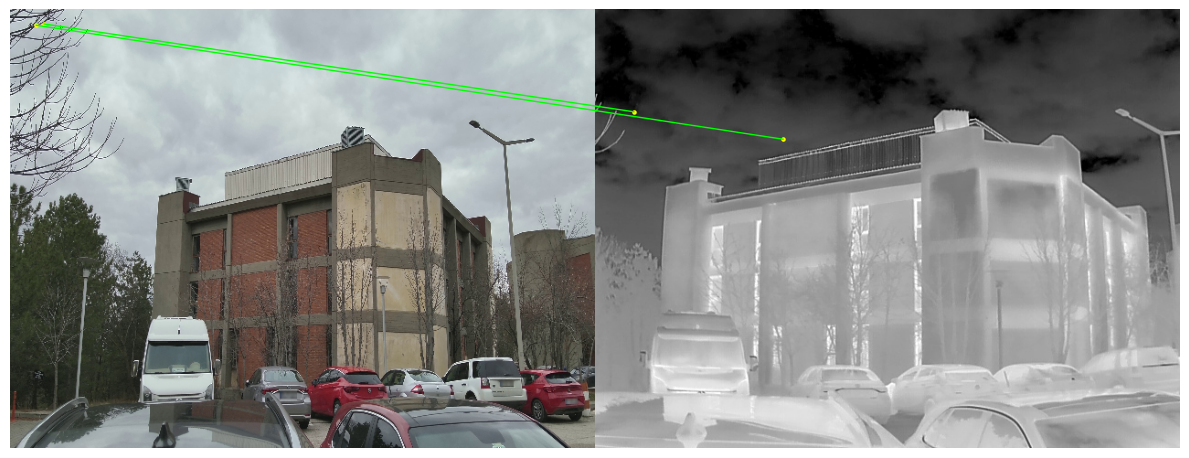

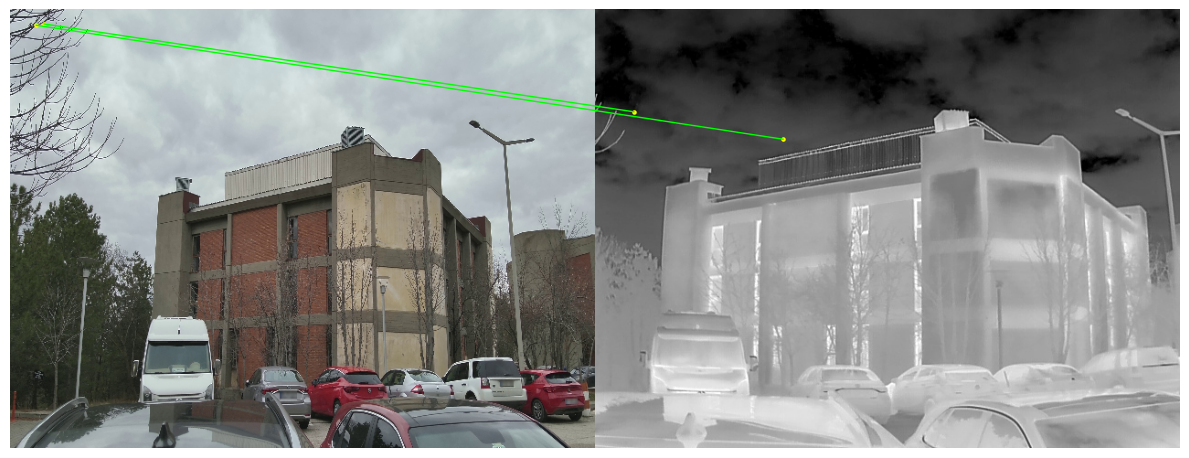

In [ ]:
import cv2
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def test_model_on_sample(model, image_path0, image_path1, device='cuda'):
    # Load images using OpenCV.
    img0 = cv2.imread(image_path0)
    img1 = cv2.imread(image_path1)
    if img0 is None or img1 is None:
        raise FileNotFoundError("One or both image paths are invalid.")

    # Convert from BGR to RGB
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    # Define a transform (resize to the network's expected size, e.g., 224x224)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224))
    ])

    image0_tensor = transform(img0).unsqueeze(0).to(device)  # [1, C, H, W]
    image1_tensor = transform(img1).unsqueeze(0).to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image0_tensor, image1_tensor)

    print("Output keys:", output.keys())
    print("Refined keypoints0 shape:", output["refined_keypoints0"].shape)
    print("Descriptors0 shape:",       output["descriptors0"].shape)

    # Now visualize with the fixed function:
    visualize_matches_fixed2(image_path0, image_path1, output)
    visualize_matches_fixed2(image_path0, image_path1, output, save_path=None)

# Example usage:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HybridModel_SG(matching_type="superglue", debug_backbone=True, scale_aware=True).to(device)
# Replace these paths with your actual image paths
image_path0 = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/visible/images/IM_00006.jpg"
image_path1 = "/content/drive/MyDrive/ThermalNet/METU_VisTIR/cloudy/scene_1/thermal/images/IM_00006.jpg"
test_model_on_sample(model, image_path0, image_path1, device=device)
